# Mercari Price Suggestion Challenge

In this competition, Mercari’s challenging us to build an algorithm that automatically suggests the right product prices. You’ll be provided user-inputted text descriptions of their products, including details like product category name, brand name, and item condition.


## Steps Followed

* A
* B
* C

In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import bokeh
import plotly

In [1]:

import nltk
import string
#import rea
import numpy as np
import pandas as pd
import pickle
#import lda

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

from nltk.stem.porter import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction import stop_words

from collections import Counter
#from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook
#from bokeh.transform import factor_cmap

import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger("lda").setLevel(logging.WARNING)

c:\users\sukes\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


### Data Sourcing

In [2]:
# Reading the data
train = pd.read_csv('C:/Users/sukes/Desktop/Projects/product_price_prediction_NLP/train.tsv',sep='\t')
test = pd.read_csv('C:/Users/sukes/Desktop/Projects/product_price_prediction_NLP/test.tsv',sep='\t')

In [3]:
# Looking into the data
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29999 entries, 0 to 29998
Data columns (total 8 columns):
train_id             29999 non-null int64
name                 29999 non-null object
item_condition_id    29999 non-null int64
category_name        29854 non-null object
brand_name           17123 non-null object
price                29999 non-null float64
shipping             29999 non-null int64
item_description     29999 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 1.4+ MB


In [5]:
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29999 entries, 0 to 29998
Data columns (total 7 columns):
test_id              29999 non-null int64
name                 29999 non-null object
item_condition_id    29999 non-null int64
category_name        29855 non-null object
brand_name           17150 non-null object
shipping             29999 non-null int64
item_description     29999 non-null object
dtypes: int64(3), object(4)
memory usage: 1.1+ MB


### Exploratory Data Analysis

On the first look at the data, besides the unique identifier (item_id), there are 7 variables in this model. This notebook will sequentially go through each of them with a brief statistical summary.

**Numerical/Continuous Features**

    A.price: the item's final bidding price. This will be our reponse / independent variable that we need to predict test set
    B.shipping cost
**Categorical Features:**

    shipping cost: A binary indicator, 1 if shipping fee is paid by seller and 0 if it's paid by buyer
    item_condition_id: The condition of the items provided by the seller
    name: The item's name
    brand_name: The item's producer brand name
    category_name: The item's single or multiple categories that are separated by "\"
    item_description: A short description on the item that may include removed words, flagged by [rm]

#### Target Variable Price

In [7]:
train.price.describe()

count    29999.000000
mean        26.953582
std         40.394998
min          0.000000
25%         10.000000
50%         17.000000
75%         29.000000
max       1506.000000
Name: price, dtype: float64

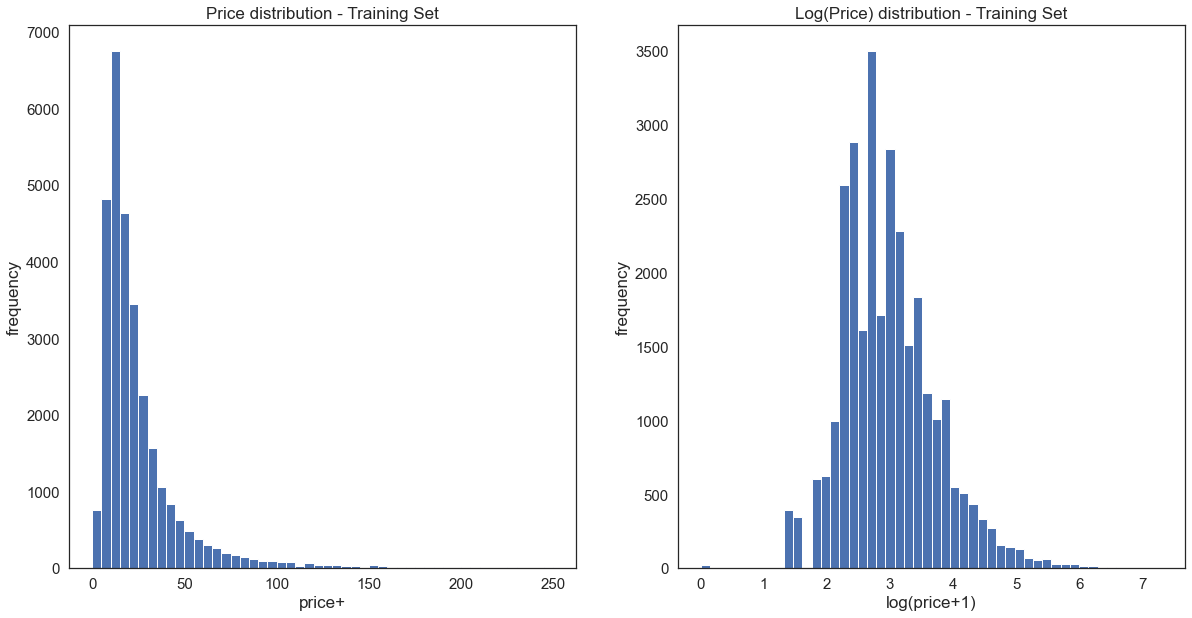

In [28]:
plt.subplot(1,2,1)
(train['price']).plot.hist(bins=50,figsize=(20,10),edgecolor='white', range =[0,250])
plt.xlabel('price+',fontsize=17)
plt.ylabel('frequency',fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Price distribution - Training Set',fontsize=17)

plt.subplot(1,2,2)
np.log(train['price']+1).plot.hist(bins=50,figsize=(20,10),edgecolor='white', )
plt.xlabel('log(price+',fontsize=17)
plt.ylabel('frequency',fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Log(Price) distribution - Training Set',fontsize=17)

plt.show()

The next standard check is with our response or target variables, which in this case is the price we are suggesting to the Mercari's marketplace sellers. The median price of all the items in the training is about \$267 but given the existence of some extreme values of over \$100 and the maximum at \$2,009, the distribution of the variables is heavily skewed to the left. So let's make log-transformation on the price (we added +1 to the value before the transformation to avoid zero and negative values).

#### Shipping Variable

In [8]:
train.shipping.value_counts()/len(train)

0    0.552285
1    0.447715
Name: shipping, dtype: float64

In [9]:
prc_shipBySeller = train.loc[train.shipping==1,'price']
prc_shipByBuyer = train.loc[train.shipping==0,'price']

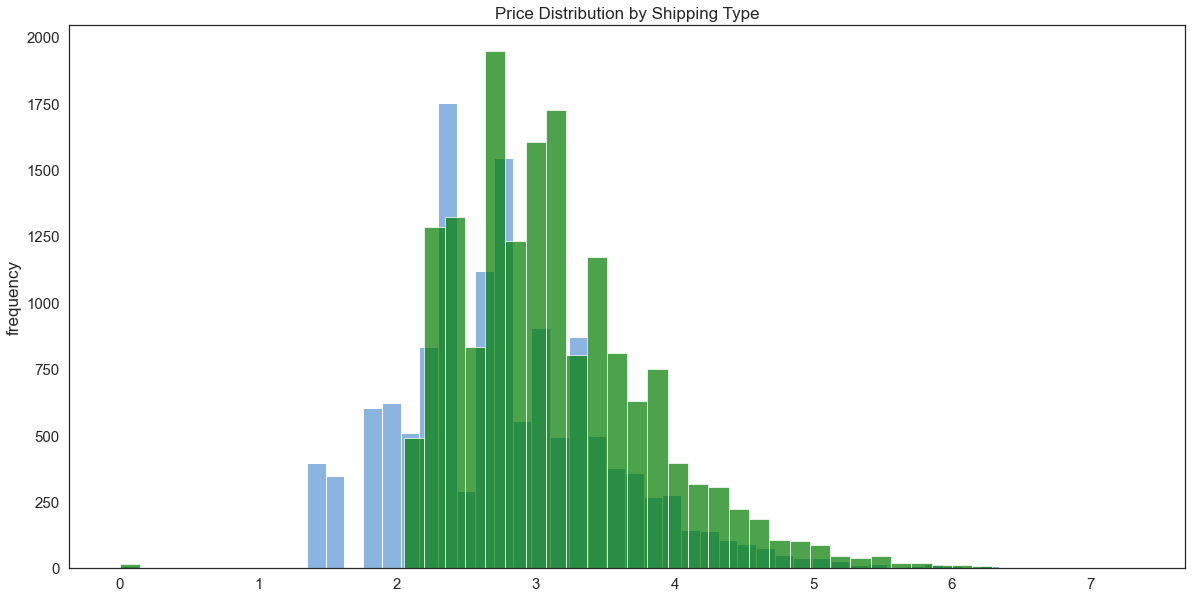

In [13]:
fig, ax = plt.subplots(figsize=(20,10))
ax.hist(np.log(prc_shipBySeller+1),
       color='#8CB4E1',
       alpha=1.0,
       bins=50,
       label='Price when Seller pays Shipping')
ax.hist(np.log(prc_shipByBuyer+1),
       color='#007D00',
       alpha=0.7,
       bins=50,
       label='Price When Buyer pays Shipping')
plt.ylabel('frequency', fontsize=17)
plt.title('Price Distribution by Shipping Type', fontsize=17)
plt.tick_params(labelsize=15)
plt.show()

The shipping cost burden is decently splitted between sellers and buyers with more than half of the items' shipping fees are paid by the sellers (55%). In addition, the average price paid by users who have to pay for shipping fees is lower than those that don't require additional shipping cost. This matches with our perception that the sellers need a lower price to compensate for the additional shipping.

#### Item category

In [15]:
print(f'There are {train.category_name.nunique()} unique items in the "Attribute Item Category"')

There are 807 unique items in the "Attribute Item Category"


In [16]:
# Top 5 categories
train['category_name'].value_counts().head(5)

Women/Athletic Apparel/Pants, Tights, Leggings    1211
Women/Tops & Blouses/T-Shirts                      910
Beauty/Makeup/Face                                 727
Beauty/Makeup/Lips                                 669
Beauty/Makeup/Eyes                                 549
Name: category_name, dtype: int64

In [17]:
print(f'There are {train.category_name.isnull().sum()} items that do not have label')

There are 145 items that do not have label


In [20]:
def split_cat(text):
    try:
        return text.split('/')
    except:
        return ('No Label','No Label','No Label')

In [23]:
train['general_cat'], train['subcat_1'], train['subcat_2'] = zip(*train.category_name.apply(lambda x: split_cat(x)))

In [25]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [26]:
# repeat the same step for the test set
test['general_cat'], test['subcat_1'], test['subcat_2'] = \
zip(*test['category_name'].apply(lambda x: split_cat(x)))

In [27]:
print("There are %d unique in general category (Main category)" % train['general_cat'].nunique())
print("There are %d unique first sub-categories." % train['subcat_1'].nunique())
print("There are %d unique second sub-categories." % train['subcat_2'].nunique())


There are 11 unique in general category (Main category)
There are 110 unique first sub-categories.
There are 594 unique second sub-categories.


In [36]:
# Lets look at the plot of Main cartegories distribution
x = train.general_cat.value_counts().index.values.astype('str')
y = train['general_cat'].value_counts().values

In [46]:
pct  = [str(round((i/sum(y))*100,2)) + '%' for i in y]

In [50]:
trace1 = go.Bar(x=x,
                y=y,
                text=pct)
layout = dict(title='Number of Items by Main Category',
             xaxis=dict(title='Category'),
             yaxis=dict(title='Count'))
fig = dict(data=[trace1,],layout=layout)
py.iplot(fig)

In [51]:
# Lets look at the plot of sub-Category 1 distribution
x = train['subcat_1'].value_counts().index.values.astype('str')[:15]
y = train['subcat_1'].value_counts().values[:15]
pct = [("%.2f"%(v*100))+"%"for v in (y/len(train))][:15]

In [52]:
trace1 = go.Bar(x=x, y=y, text=pct,
                marker=dict(
                color = y,colorscale='Portland',showscale=True,
                reversescale = False
                ))
layout = dict(title= 'Number of Items by Sub Category (Top 15)',
              yaxis = dict(title='Count'),
              xaxis = dict(title='SubCategory'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

In [55]:
# Let's look at Main category vs Price
general_cats = train['general_cat'].unique()
x = [train.loc[train['general_cat']==cat, 'price'] for cat in general_cats]

In [62]:
data = [go.Box(x=np.log(x[i]+1), name=general_cats[i]) for i in range(len(general_cats))]

In [63]:
layout = dict(title="Price Distribution by General Category",
              yaxis = dict(title='Frequency'),
              xaxis = dict(title='Category'))
fig = dict(data=data, layout=layout)
py.iplot(fig)

#### Brand Name

In [64]:
print("There are %d unique brand names in the training dataset." % train['brand_name'].nunique())

There are 1231 unique brand names in the training dataset.


In [65]:
x = train['brand_name'].value_counts().index.values.astype('str')[:10]
y = train['brand_name'].value_counts().values[:10]

In [66]:
trace1 = go.Bar(x=x, y=y, 
                marker=dict(
                color = y,colorscale='Portland',showscale=True,
                reversescale = False
                ))
layout = dict(title= 'Top 10 Brand by Number of Items',
              yaxis = dict(title='Brand Name'),
              xaxis = dict(title='Count'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

#### Item Description

In [ ]:
def word_count(text):
    try:
        # convert to lower case
        text = text.lower()
        regex = re.compile('['+re.escape(string.punctuation)+'0-9\\r\\t\\n')
        txt = regex.sub(' ', text)